In [ ]:
import torch, torchvision, os
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip install imantics
!pip uninstall imgaug && pip uninstall albumentations &&  pip install git+https://github.com/aleju/imgaug.git && pip uninstall Pillow && pip install -U Pillow
#assert torch.__version__.startswith("1.6")
os.kill(os.getpid(), 9)

y
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.4.0
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-l4ugiwm7
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-l4ugiwm7
y
y
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=6bc1db95e199bb310c58d98f54d0904888c699995a3f3675169c33b2123ca787
  Stored in directory: /tmp/pip-ephem-wheel-cache-ernavtm1/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
Uninstalling Pillow-8.0.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-8.0.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/Pillow.libs/libXau-312dbc56.so.6.0.0
    /usr/local/lib/python3.6/dist-packages/Pillow.libs/lib

In [1]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

y
y
y
y
y
y
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 5.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-any.whl size=44419 sha256=4edfa2f43a6854f6062d22fac86515edc84cca87c280c11529c5dbb221e47484
  Stored in directory: /root/.cache/pip/wheels/ec/4d/40/4077356fe02ef345791713eabede5ed63afe7d613b016694d1
Successfully built fvcore


In [2]:
from detectron2.utils.logger import setup_logger

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer


class TrainingInstance():

    def __init__(self, training_data_name, annotations, pictures, iterations=500, num_classes=2,
                 weights=model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")):
        setup_logger()
        self.training_data_name = training_data_name
        register_coco_instances(self.training_data_name, {}, annotations, pictures)
        self.iterations = iterations
        self.num_classes = num_classes
        self.cfg = None
        self.weights = weights
        self.trainer = self.initialize_trainer(self.training_data_name, self.iterations, self.num_classes)

    def initialize_trainer(self, train, iterations, num_classes):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.DATASETS.TRAIN = (train,)
        self.cfg.DATASETS.TEST = ()
        self.cfg.DATALOADER.NUM_WORKERS = 2
        self.cfg.MODEL.WEIGHTS = self.weights  # Let training initialize from model zoo
        self.cfg.SOLVER.IMS_PER_BATCH = 2
        self.cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
        self.cfg.SOLVER.MAX_ITER = iterations
        self.cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this dataset (default: 512)
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # number of classes in your training dataset

        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)
        model = DefaultTrainer(self.cfg)
        model.resume_or_load(resume=False)
        return model

    def train(self):
        self.trainer.train()
        self.weights = os.path.join(self.cfg.OUTPUT_DIR,
                                    "model_final.pth")

    def prediction_on_one_image(self, img):
        self.cfg.MODEL.WEIGHTS = self.weights  # path to the model we just trained
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.80  # set a custom testing threshold
        predictor = DefaultPredictor(self.cfg)

        im = cv2.imread(img)

        outputs = predictor(im)
        # We can use `Visualizer` to draw the predictions on the image.
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]), scale=1.2)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(out.get_image()[:, :, ::-1])

        cv2.imwrite('output_' + img[:-4] + '.jpg', out.get_image()[:, :, ::-1])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import random
import string

letters = string.ascii_lowercase
result_str = ''.join(random.choice(letters) for i in range(8))

DATASET_NAME = result_str





ANNOTATIONS = "/content/drive/My Drive/2020.10.15-dentem/annotation/mouth1.json"
PICTURES = "/content/drive/My Drive/2020.10.15-dentem/images"

#fourth argument is the path to a trained model; leave empty to use the default weights
#instance = TrainingInstance(DATASET_NAME,ANNOTATIONS,PICTURES,3000,10, '/content/drive/My Drive/Dental Guard Shared/model_final.pth')

instance = TrainingInstance(DATASET_NAME,ANNOTATIONS,PICTURES,3300,4,)
instance.train()

[11/04 21:13:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[11/04 21:13:44 d2.engine.train_loop]: Starting training from iteration 0
[11/04 21:13:54 d2.utils.events]:  eta: 0:27:34  iter: 19  total_loss: 3.996  loss_cls: 1.601  loss_box_reg: 0.857  loss_mask: 0.693  loss_rpn_cls: 0.678  loss_rpn_loc: 0.169  time: 0.4980  data_time: 0.0146  lr: 0.000005  max_mem: 2763M
[11/04 21:14:04 d2.utils.events]:  eta: 0:27:23  iter: 39  total_loss: 3.657  loss_cls: 1.498  loss_box_reg: 0.863  loss_mask: 0.683  loss_rpn_cls: 0.448  loss_rpn_loc: 0.162  time: 0.4953  data_time: 0.0047  lr: 0.000010  max_mem: 2763M
[11/04 21:14:15 d2.utils.events]:  eta: 0:27:38  iter: 59  total_loss: 3.260  loss_cls: 1.334  loss_box_reg: 0.889  loss_mask: 0.663  loss_rpn_cls: 0.234  loss_rpn_loc: 0.136  time: 0.5048  data_time: 0.0050  lr: 0.000015  max_mem: 2763M
[11/04 21:14:25 d2.utils.events]:  eta: 0:27:34  iter: 79  total_loss: 2.952  loss_cls: 1.109  loss_box_reg: 0.853  loss_mask: 0.640  loss_rpn_cls: 0.144  loss_rpn_loc: 0.153  time: 0.5060  data_time: 0.0049  lr:

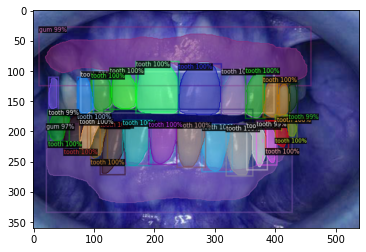

In [22]:
instance.prediction_on_one_image('/content/drive/My Drive/Dental Test/300pix/0004.jpg')